# Machine Learning Engineer Nanodegree
# Capstone Project


## Analysis
------
### Getting started

We first import some libraries and our dataset containing information gathered using the official Meetup API.

Our dataset is a list of users represented as Python dictionaries with the following information:
- City
- Id
- Profile link
- Name
- Topics
    - name
    - urlkey
    - id

In [18]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from collections import Counter
import cPickle as pickle
import pprint
%matplotlib inline

members_data = pickle.load(open( "Miami_meetup_members_save.p", "rb" ) )     
df = pd.DataFrame(members_data)
df.head(n=10)

,city,id,link,name,topics
0,Miami,1837039,http://www.meetup.com/members/1837039,...Adeela!,[]
1,Miami,50171992,http://www.meetup.com/members/50171992,"""Jay"" - Jennifer","[{u'name': u'Black Professionals', u'urlkey': ..."
2,Miami,203909843,http://www.meetup.com/members/203909843,Aaron Wallace,"[{u'name': u'Pets', u'urlkey': u'pets-animals'..."
3,Minneapolis,145409602,http://www.meetup.com/members/145409602,abby,"[{u'name': u'Pug', u'urlkey': u'pug', u'id': 5..."
4,Miami,201741842,http://www.meetup.com/members/201741842,abi,"[{u'name': u'Artists', u'urlkey': u'boston-art..."
5,Miami,8484098,http://www.meetup.com/members/8484098,ADOLFO ROBIOU,[]
6,Miami Beach,5694840,http://www.meetup.com/members/5694840,Aimee,[]
7,New York,193427043,http://www.meetup.com/members/193427043,Alan Etienne,"[{u'name': u'NFL Football', u'urlkey': u'nflfo..."
8,Miami Beach,32100452,http://www.meetup.com/members/32100452,Alan Rubio,[]
9,Miami Beach,10645541,http://www.meetup.com/members/10645541,Alana and Max,[]


From the first 10 entries we notice some discrepancies. Even though in our request to Meetup's API we queried only groups in a 15 mile radius around Miami, we notice some users, members of these groups, have a different city indicated in their profile. However this doesn't interfere with our problem solution.
More importantly, some users don't have any interest indicated on their profile. Therefore they cannot be used for this project.
We proceed to remove these entries.

In [67]:
cl_df = df[df.astype(unicode)['topics'] != '[]']
cl_df.reset_index(inplace=True)
cl_df.head()

,index,city,id,link,name,topics
0,1,Miami,50171992,http://www.meetup.com/members/50171992,"""Jay"" - Jennifer","[{u'name': u'Black Professionals', u'urlkey': ..."
1,2,Miami,203909843,http://www.meetup.com/members/203909843,Aaron Wallace,"[{u'name': u'Pets', u'urlkey': u'pets-animals'..."
2,3,Minneapolis,145409602,http://www.meetup.com/members/145409602,abby,"[{u'name': u'Pug', u'urlkey': u'pug', u'id': 5..."
3,4,Miami,201741842,http://www.meetup.com/members/201741842,abi,"[{u'name': u'Artists', u'urlkey': u'boston-art..."
4,7,New York,193427043,http://www.meetup.com/members/193427043,Alan Etienne,"[{u'name': u'NFL Football', u'urlkey': u'nflfo..."


In [68]:
print "Total count of profiles with at least one interest is: %d" % (cl_df.shape[0])

Total count of profiles with at least one interest is: 82186


For each entry, the topics column contains a list of dictionaries that give additional information about each topic. This information is useful but preprocessing is needed. We create a new column that is only a list of topics' names and call it "interests".
At the same time we count the number of times an interest is indicated and then display the 20 most common interests.

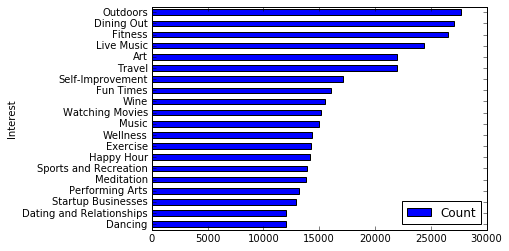

In [69]:
interests = []
c = Counter()
for row in cl_df['topics']:
    user_interests = []
    for interest in row:
        user_interests.append(interest['name'])
    interests.append(user_interests)
    c.update(user_interests)
cl_df.loc[:,'interests'] = interests
counter = pd.DataFrame()
counter['Interest'], counter['Count'] = zip(*c.most_common(20))
counter.sort_index(axis=0 ,ascending=False).plot(x='Interest', kind='barh')

In [70]:
print "There are %s unique interests" % len(c)

There are 21892 unique interests


It would be useful to obtain an histogram showing the number of interests each person has indicated. We create an additional column with this number.

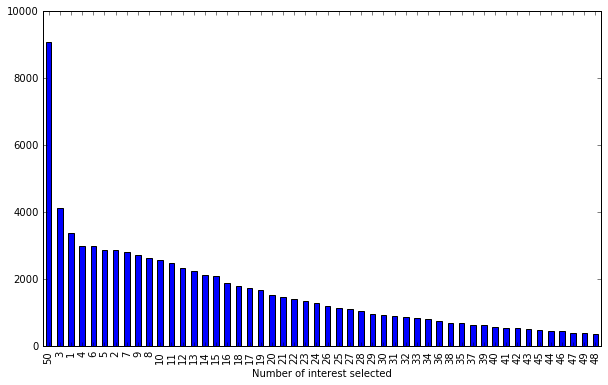

In [71]:
interests_count = []
for row in cl_df['interests']:
    num_of_interests = len(row)
    interests_count.append(num_of_interests)
cl_df.loc[:,'interests_count'] = interests_count
interest_count_plot = cl_df['interests_count'].value_counts().plot(kind='bar', figsize=(10,6))
interest_count_plot.set_xlabel("Number of interest selected")

We now proceed to extract all the features and vectorize our corpus using TfidfVectorizer which includes a TfidfTransformer. We create a matrix where each row represents a document/user and each column a token/interest.

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

def my_tokenizer(mylist):
    return mylist

vectorizer = TfidfVectorizer(tokenizer = my_tokenizer, lowercase = False)
X = vectorizer.fit_transform(x for x in cl_df["interests"])
print "Number of rows: %d" % X.shape[0]
print "Number of columns: %d" % X.shape[1]

Number of rows: 82186
Number of columns: 21892


In [73]:
from sklearn.metrics.pairwise import cosine_similarity
def compute_similarity(X, index, match_num = 5):
    sims = cosine_similarity(X[index,:],X)
    sim_list = np.argsort(sims)
    #Reverse and select only the number of matching users indicated by match_num
    sim_list = sim_list[0][::-1][0:match_num+1]
    match_list = []
    for i in sim_list:
        #remove the queried user from the match list
        if i != index:
            match_list.append((i, sims[:,i][0]))
    return match_list
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(compute_similarity(X, 4325, match_num=10))

[ (56090, 1.0),
  (55995, 1.0),
  (55774, 0.95236044136229014),
  (17375, 0.95236044136229014),
  (55823, 0.86417102531441214),
  (56001, 0.83555621569324401),
  (17524, 0.81316339861122278),
  (1602, 0.80958605223329849),
  (48407, 0.78371376889767008),
  (55833, 0.75329761507993198)]


In [90]:
def compare_interests(corpus, user_index, match_list):
    print "Queried user has {0} interests: {1} \n".format(len(corpus[user_index]), corpus[user_index])
    for index, item in enumerate(match_list):
        i, j = item
        shared_interests = set(corpus.loc[user_index]) & set(corpus.loc[i])
        print "Match #{0}".format(index+1)
        print "Match score with {0}: {1}".format(i, j)
        print "Interests of {0}: {1}".format(i, corpus[i])
        print "Number of shared interests: {0}".format(len(shared_interests))
        print "Shared interests: {0} ".format(shared_interests)
        print "\n"
compare_interests(cl_df["interests"], 4325, compute_similarity(X, 4325, match_num=6))
    

Queried user has 3 interests: [u'Fitness', u'Vegetarian', u'Vegan'] 

Match #1
Match score with 56090: 1.0
Interests of 56090: [u'Fitness', u'Vegetarian', u'Vegan']
Number of shared interests: 3
Shared interests: set([u'Vegetarian', u'Vegan', u'Fitness']) 


Match #2
Match score with 55995: 1.0
Interests of 55995: [u'Fitness', u'Vegetarian', u'Vegan']
Number of shared interests: 3
Shared interests: set([u'Vegetarian', u'Vegan', u'Fitness']) 


Match #3
Match score with 55774: 0.952360441362
Interests of 55774: [u'Vegan', u'Vegetarian']
Number of shared interests: 2
Shared interests: set([u'Vegetarian', u'Vegan']) 


Match #4
Match score with 17375: 0.952360441362
Interests of 17375: [u'Vegetarian', u'Vegan']
Number of shared interests: 2
Shared interests: set([u'Vegetarian', u'Vegan']) 


Match #5
Match score with 55823: 0.864171025314
Interests of 55823: [u'Vegetarian', u'Vegan', u'Spirituality']
Number of shared interests: 2
Shared interests: set([u'Vegetarian', u'Vegan']) 


Match #

Logically users with a lower number of interests indicated are more likely to have a higher matching score with other users because it is easier for other users to have all their interests since they indicated so few.

Though 2 more interesting appear from the example above:
- The 5th matching user has a score of 0.86, significantly lower than the 3rd and 4th matching users (with a score of 0.95) even though the 5th matching user has all their interests (namely "Vegeterian" and "Vegan"). This means that the algorithm penalizes having additional non-shared interests in terms of similarity. This might be a far-fetched deduction. What if the queried person simply forgot to indicate that she also likes Spirituality? What's more what if the 4th match forgot to indicate that she likes Hiking, which the queried user hates?

- Even more worrisome is the fact that the 6th matching user has all the interests of the queried user but is only in the 6th position after users with only 2 matching interests! This is a poor performance if we take the number of shared interests as a metric to evaluate our algorithm.

In [84]:
print cl_df["interests"][56090]
print cl_df["interests"][56001]


[u'Fitness', u'Vegetarian', u'Vegan']
[u'Fitness', u'Vegetarian', u'Vegan', u'Organic Foods']


In [66]:
cl_df[100:200]

,city,id,link,name,topics,interests,interests_count
177,Miami Beach,3775795,http://www.meetup.com/members/3775795,Flegery,"[{u'name': u'Dog Rescue', u'urlkey': u'dogresc...","[Dog Rescue, Pug]",2
180,Miami,195853296,http://www.meetup.com/members/195853296,Francisco,"[{u'name': u'Fitness', u'urlkey': u'fitness', ...","[Fitness, Comedy, Self-Improvement, Men's Soci...",8
181,Miami Beach,66582772,http://www.meetup.com/members/66582772,Gabriel Carreras,"[{u'name': u'Fitness', u'urlkey': u'fitness', ...","[Fitness, Live Music, Cooking, Recipes]",4
182,Miami Beach,190419080,http://www.meetup.com/members/190419080,Gabriel Ivory,"[{u'name': u'Fitness', u'urlkey': u'fitness', ...","[Fitness, Kayaking, Beach, Fun Times, Happy Ho...",7
183,Miami Beach,203757284,http://www.meetup.com/members/203757284,gabriela fernandez,"[{u'name': u'Art', u'urlkey': u'art', u'id': 1...","[Art, professional-networking, wine-and-food-p...",32
184,Miami,105311792,http://www.meetup.com/members/105311792,George calleja,"[{u'name': u'Latin Music', u'urlkey': u'latinm...","[Latin Music, Pug, Watching Movies, Skin Care,...",26
186,Tampa,186890506,http://www.meetup.com/members/186890506,Gian Piero,"[{u'name': u'Art', u'urlkey': u'art', u'id': 1...","[Art, Architecture, French Bulldog, Museum, Ac...",8
189,Pompano Beach,3664639,http://www.meetup.com/members/3664639,Gina,"[{u'name': u'Latin Music', u'urlkey': u'latinm...","[Latin Music, Coffee, Salsa, Book Swap, Hip Ho...",41
192,Miami,12723333,http://www.meetup.com/members/12723333,Gina Gessa,"[{u'name': u'Moms', u'urlkey': u'moms', u'id':...","[Moms, Playdates, Stay-at-Home Moms]",3
193,Miami,79634862,http://www.meetup.com/members/79634862,Gina Ramirez,"[{u'name': u'Fitness', u'urlkey': u'fitness', ...","[Fitness, Wine, Walking, Meditation, Live Musi...",35


In [60]:
set(cl_df["interests"][56090]) & set(cl_df["interests"][11])

KeyError: 56090L